In [269]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns


In [286]:
class Graph:
    def __init__(self, num_cities, dist_matrix=None, low=3, high=50):
        self.num_cities = num_cities
        if dist_matrix is not None:
            self.dist_matrix = dist_matrix
        else:
            self.dist_matrix = self.generate_distances(num_cities, low, high)

    '''
    for ex
    [[ 0  6  8  5]
     [ 6  0 10  4]
     [ 8 10  0  9]
     [ 5  4  9  0]]

    '''
    @staticmethod

    def generate_distances(num_cities, low=3, high=50):
        dist = np.zeros((num_cities, num_cities), dtype=int)
        for i in range(num_cities):
            for j in range(i + 1, num_cities):
                distance = random.randint(low, high)
                dist[i, j] = dist[j, i] = distance
        return dist

    '''
        path = [0, 2, 3, 1]

        cost = 0
        cost += dist[0][2] = 8
        cost += dist[2][3] = 9
        cost += dist[3][1] = 4
        cost += dist[1][0] = 6
        '''
    @staticmethod

    def path_cost(path, dist_matrix):
        cost = 0
        for i in range(len(path) - 1):
            cost += dist_matrix[path[i], path[i + 1]]
        cost += dist_matrix[path[-1], path[0]]  # Return to start
        return cost

In [271]:
class Ant:
    def __init__(self, graph:Graph, pheromone, alpha=1, beta=5):
        ''''
            3. Create a graph representation of the potential solutions, where each node
              represents a location and each edge represents a path between two locations.
         '''
        self.graph = graph
        self.dist_matrix = graph.dist_matrix
        self.num_cities = graph.num_cities

        self.pheromone = pheromone
        self.alpha = alpha
        self.beta = beta
        self.path = []
        self.visited = set()

    def select_next_city(self):
        '''
        b. For each ant, choose a path to follow from the starting point to the endpoint
        using a probabilistic decision rule that is based on the pheromone levels on the edges.
         prob = (τ^α * η^β) / ∑(τ^α * η^β)
        '''
        current = self.path[-1] # start with the last city in the path now

        unvisited = [city for city in range(self.num_cities) if city not in self.visited]
        if not unvisited:
            return None

        probabilities = []

        #∑(τ^α⋅η^β).
        denominator = 0
        for city in unvisited:
            tau = self.pheromone[current][city] ** self.alpha
            eta = (1 / self.dist_matrix[current][city]) ** self.beta
            denominator += tau * eta

            # probabiltiy for each city
            #Pij= (τ_ij)^α⋅(η_ij)^β /denominator


        for city in unvisited:
            tau = self.pheromone[current][city] ** self.alpha
            eta = (1 / self.dist_matrix[current][city]) ** self.beta
            prob = (tau * eta) / denominator if denominator > 0 else 0
            probabilities.append(prob)

        #Roulette Wheel Selection
        r = random.random()
        cumulative = 0
        for city, prob in zip(unvisited, probabilities):
            cumulative += prob
            if r <= cumulative:
                return city
        return unvisited[-1] # default to the last city if no selection is made

    def build_partial_path(self):
        '''
        2. Randomly generate a set of potential solutions to the optimization problem,
         where each solution is represented as a path between the starting point and the endpoint.

        1. More Exploration
            Ants try different partial paths → helps find better solutions.

        2. Avoid Early Mistakes
            If an ant picks a bad full path from the start, it's hard to fix. Partial path = less risk.

        3. Faster Search
            Building short paths is quicker → try more options in less time.
        '''
        start = random.randint(0, self.num_cities - 1)
        self.path = [start]
        self.visited = {start}
        target_len = self.num_cities // 2

        while len(self.path) < target_len:
            next_city = self.select_next_city()
            if next_city is None:
                break
            self.path.append(next_city)
            self.visited.add(next_city)

    def complete_path(self):
        while len(self.visited) < self.num_cities:
            next_city = self.select_next_city()
            if next_city is None:
                break
            self.path.append(next_city)
            self.visited.add(next_city)


In [272]:

class Colony:
    ''''
        1. Initialize the parameters of the algorithm, including the number of Ants M,
    the pheromone evaporation rate ρ, and the initial pheromone level on
    the edges τxy .
    '''
    def __init__(self,  graph: Graph, num_ants, alpha=1, beta=5, rho=0.1, Q=100):
        self.graph = graph
        self.dist_matrix = graph.dist_matrix
        self.num_cities = graph.num_cities

        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        self.pheromone = np.ones((self.num_cities, self.num_cities))  # τ_xy = 1 at first
        self.ants = []
        self.best_path = None
        self.best_cost = float('inf')
        self.pheromone_snapshots = []
        self.best_paths_snapshots = []


    def create_ants(self):
        '''
            a. Release a group of artificial ants onto the graph, where each ant is placed at the starting point.
        '''
        self.ants = [Ant(self.graph, self.pheromone, self.alpha, self.beta)
                 for _ in range(self.num_ants)]

    def combine_partial_paths(self):
        partial_paths = {}
        for ant in self.ants:
            key = tuple(ant.path)
            if key not in partial_paths:
                partial_paths[key] = []
            partial_paths[key].append(ant)
            '''
            {
                (0, 2, 3): [Ant A, Ant B],
                (1, 4, 5): [Ant C, Ant E],
                (2, 1, 0): [Ant D]
            }
            '''

        combined_ants = []
        for key, group in partial_paths.items():
            if len(group) > 1:
                rep_ant = group[0] # if more that ant ,first ant to continue
                rep_ant.complete_path()
                combined_ants.append(rep_ant)
            else:
                group[0].complete_path()
                combined_ants.append(group[0])

        self.ants = combined_ants

    def update_pheromones(self):
        '''
        c. Update the pheromone levels on the edges based on the quality of
        the solutions found by the ants. The pheromone level on each edge is increased by
        delta[x, y] += self.Q / L

        d. Evaporate the pheromone on each edge by a fixed amount, to prevent the pheromone from accumulating indefinitely and allow the ants to adapt to changing conditions.
        '''
        delta = np.zeros_like(self.pheromone)
        for ant in self.ants:
            L = Graph.path_cost(ant.path, self.dist_matrix)
            for i in range(len(ant.path) - 1):
                x, y = ant.path[i], ant.path[i + 1]
                delta[x, y] += self.Q / L
                delta[y, x] += self.Q / L

            x, y = ant.path[-1], ant.path[0] # Return to start
            delta[x, y] += self.Q / L
            delta[y, x] += self.Q / L

        self.pheromone = self.pheromone * (1 - self.rho) + delta

    def run(self, iterations=50):
        '''
        e. Determine whether a stopping criterion has been met, such as a maximum number of iterations or a satisfactory level of solution quality. Algorithm Steps

        '''
        best_costs_per_iteration = []
        average_costs_per_iteration = []



        for it in range(iterations):
            self.create_ants()

            for ant in self.ants:
                ant.build_partial_path()

            self.combine_partial_paths()
            self.update_pheromones()
            avg_cost = np.mean([Graph.path_cost(ant.path, self.dist_matrix) for ant in self.ants])
            average_costs_per_iteration.append(avg_cost)

            for ant in self.ants:
                cost = Graph.path_cost(ant.path, self.dist_matrix)
                if cost < self.best_cost:
                    '''
                    6. Select the best solution found by the ants, which corresponds to the path with the strongest pheromone trail on the graph.'''
                    self.best_cost = cost
                    self.best_path = ant.path.copy()

            best_costs_per_iteration.append(self.best_cost)

            if (it + 1) % 10 == 0:
                print(f"Iteration {it + 1}/{iterations}, Best cost: {self.best_cost}")
                self.pheromone_snapshots.append(self.pheromone.copy())
                self.best_paths_snapshots.append((self.best_path.copy(), self.best_cost))


        return self.best_path, self.best_cost, best_costs_per_iteration, average_costs_per_iteration


# Usage example and testing


In [273]:

dist_10 = Graph.generate_distances(10)
dist_20 = Graph.generate_distances(20)

graph_10 = Graph(10, dist_10)
graph_20 = Graph(20, dist_20)


In [274]:
print("Distance matrix for 10 cities:")
print(dist_10)


Distance matrix for 10 cities:
[[ 0 26 40 30 12 33 28 27 32 17]
 [26  0 31 45 11 42  9 22 13 10]
 [40 31  0  4 43 45 16 29 39 10]
 [30 45  4  0 34 49  6 14 14 10]
 [12 11 43 34  0 20 29 22 19 10]
 [33 42 45 49 20  0 43 25  4 17]
 [28  9 16  6 29 43  0 45 17 15]
 [27 22 29 14 22 25 45  0  7 37]
 [32 13 39 14 19  4 17  7  0  7]
 [17 10 10 10 10 17 15 37  7  0]]


In [275]:
print("\nDistance matrix for 20 cities:")
print(dist_20)


Distance matrix for 20 cities:
[[ 0 40 26 38 40 28  6 42 27 21  9 25 46  5 50 43 45 19 30 41]
 [40  0  8 20  4 11 49 23 41  5 19 23 41  4 31 21  6 26 24  8]
 [26  8  0 24 37 31 29 27 48 35 12 42 31 19  3 37 36  8 49  3]
 [38 20 24  0 25 17 24 29 32 44  3 11 50 46 43 50 31 13 47  4]
 [40  4 37 25  0  5 50  9 36 47 16 13 36 14 39 18 36 37 17 43]
 [28 11 31 17  5  0 25 49  9  9 12 27 49  7 50  3  4  7 13 42]
 [ 6 49 29 24 50 25  0 14 31 32 16 38 35 49 18 35 29 19 17 36]
 [42 23 27 29  9 49 14  0 20 46 10 23 33 48 27 28 37  4 31 17]
 [27 41 48 32 36  9 31 20  0 25 31 23 47 16 14 13  9 11 34  8]
 [21  5 35 44 47  9 32 46 25  0 49 32 36 29 11 49 26 24 17 31]
 [ 9 19 12  3 16 12 16 10 31 49  0 29 18 21 31 27 40 44 46 34]
 [25 23 42 11 13 27 38 23 23 32 29  0 44 14  4 40 23 17 29 41]
 [46 41 31 50 36 49 35 33 47 36 18 44  0  5 13 25 25 34 48 47]
 [ 5  4 19 46 14  7 49 48 16 29 21 14  5  0 48 16 14 34 30 15]
 [50 31  3 43 39 50 18 27 14 11 31  4 13 48  0 45 32 36 21 29]
 [43 21 37 50 18  3 35 

In [276]:
def plot_pheromone_snapshots(colony, num_cities):
    print(f"Visualizing pheromone snapshots for {num_cities} cities...")
    for i, pheromone_matrix in enumerate(colony.pheromone_snapshots):
        plt.figure(figsize=(8, 6))
        sns.heatmap(pheromone_matrix, annot=False, cmap='viridis')
        plt.title(f'Pheromone Matrix after iteration {(i + 1) * 10} ({num_cities} cities)')
        plt.xlabel('City j')
        plt.ylabel('City i')
        plt.show()

## Results for 10 cities

In [277]:
ants_list = [1, 5, 10, 20]

print("Results for 10 cities:")

# Dictionary to store costs for plotting
best_costs_dict = {}
avg_costs_dict = {}

for n_ants in ants_list:
    colony = Colony(graph_10, num_ants=n_ants)
    best_path, best_cost, best_costs_list, avg_costs_list = colony.run()
    print(f"Ants: {n_ants} -> Best path cost: {best_cost}")
    best_costs_dict[n_ants] = best_costs_list
    avg_costs_dict[n_ants] = avg_costs_list






Results for 10 cities:
Iteration 10/50, Best cost: 121
Iteration 20/50, Best cost: 118
Iteration 30/50, Best cost: 107
Iteration 40/50, Best cost: 107
Iteration 50/50, Best cost: 107
Ants: 1 -> Best path cost: 107
Iteration 10/50, Best cost: 107
Iteration 20/50, Best cost: 107
Iteration 30/50, Best cost: 107
Iteration 40/50, Best cost: 107
Iteration 50/50, Best cost: 107
Ants: 5 -> Best path cost: 107
Iteration 10/50, Best cost: 107
Iteration 20/50, Best cost: 107
Iteration 30/50, Best cost: 107
Iteration 40/50, Best cost: 107
Iteration 50/50, Best cost: 107
Ants: 10 -> Best path cost: 107
Iteration 10/50, Best cost: 107
Iteration 20/50, Best cost: 107
Iteration 30/50, Best cost: 107
Iteration 40/50, Best cost: 107
Iteration 50/50, Best cost: 107
Ants: 20 -> Best path cost: 107


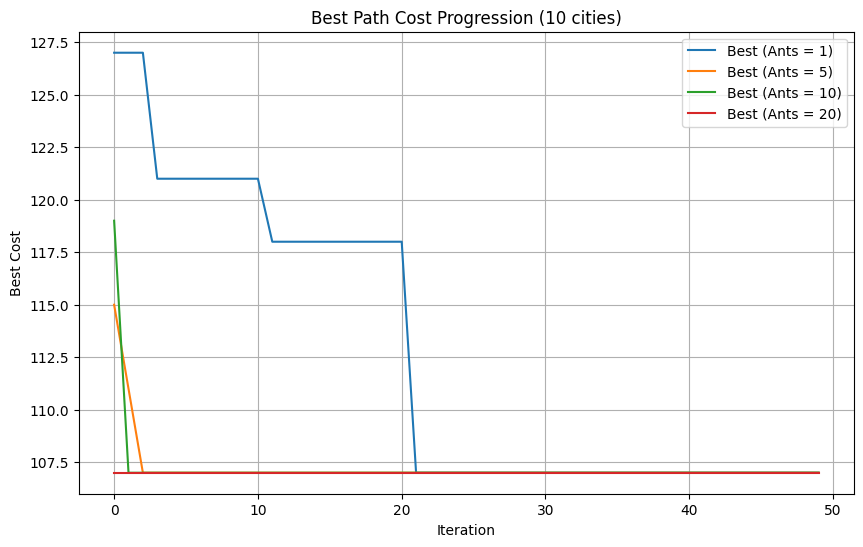

In [278]:
# Plot 1: Best cost per iteration
plt.figure(figsize=(10, 6))
for n_ants in ants_list:
    plt.plot(best_costs_dict[n_ants], label=f'Best (Ants = {n_ants})')
plt.title('Best Path Cost Progression (10 cities)')
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.legend()
plt.grid(True)
plt.show()

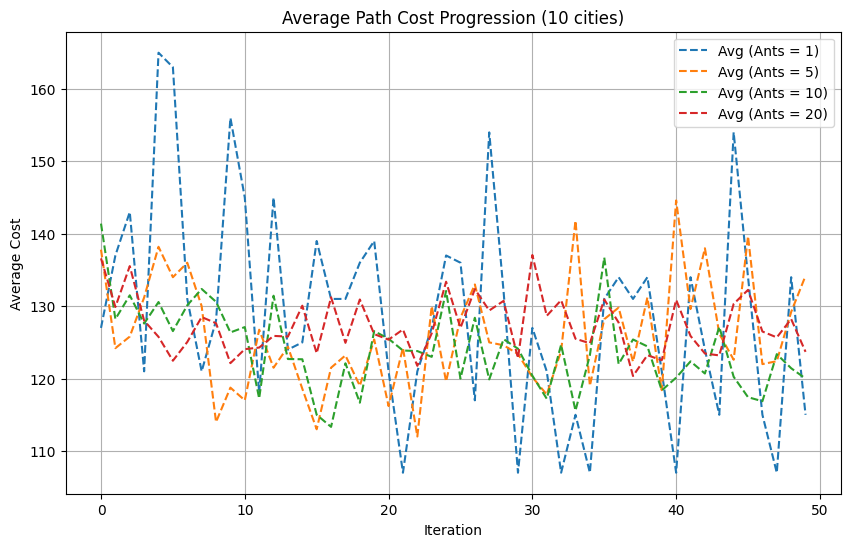

In [279]:
# Plot 2: Average cost per iteration
plt.figure(figsize=(10, 6))
for n_ants in ants_list:
    plt.plot(avg_costs_dict[n_ants], linestyle='--', label=f'Avg (Ants = {n_ants})')
plt.title('Average Path Cost Progression (10 cities)')
plt.xlabel('Iteration')
plt.ylabel('Average Cost')
plt.legend()
plt.grid(True)
plt.show()

Iteration 10/50, Best cost: 107
Iteration 20/50, Best cost: 107
Iteration 30/50, Best cost: 107
Iteration 40/50, Best cost: 107
Iteration 50/50, Best cost: 107
Visualizing pheromone snapshots for 10 cities...


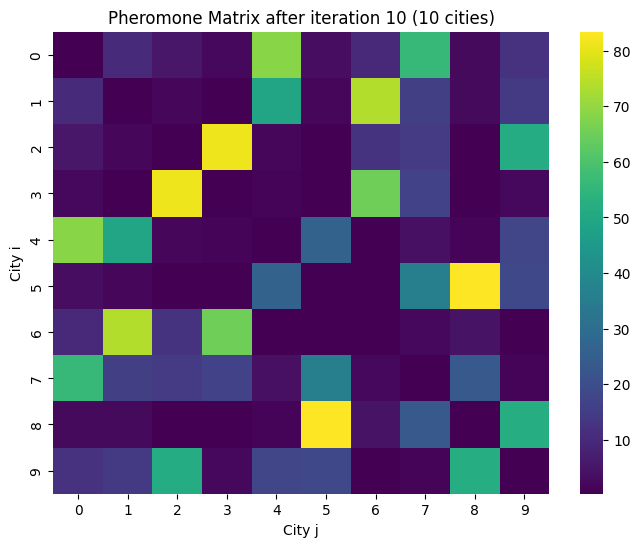

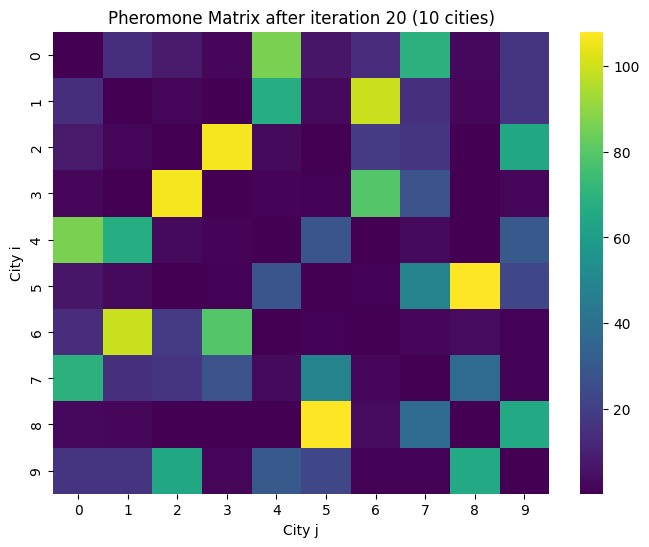

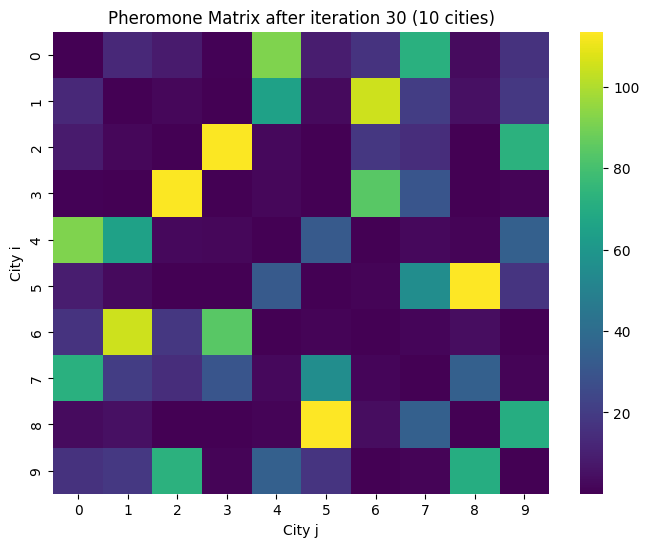

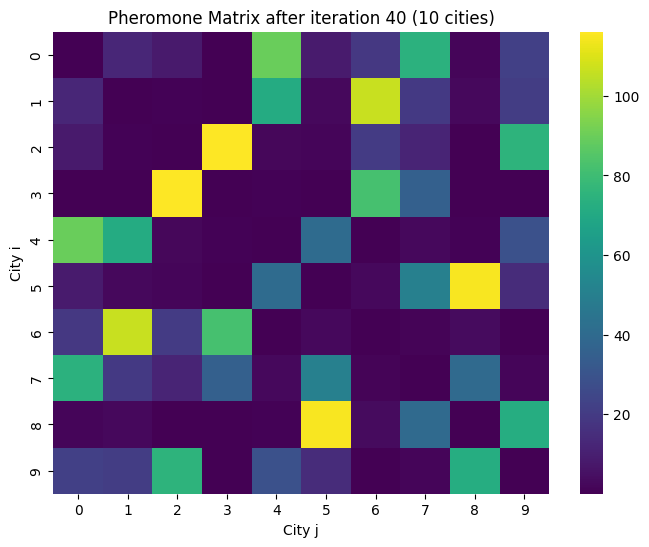

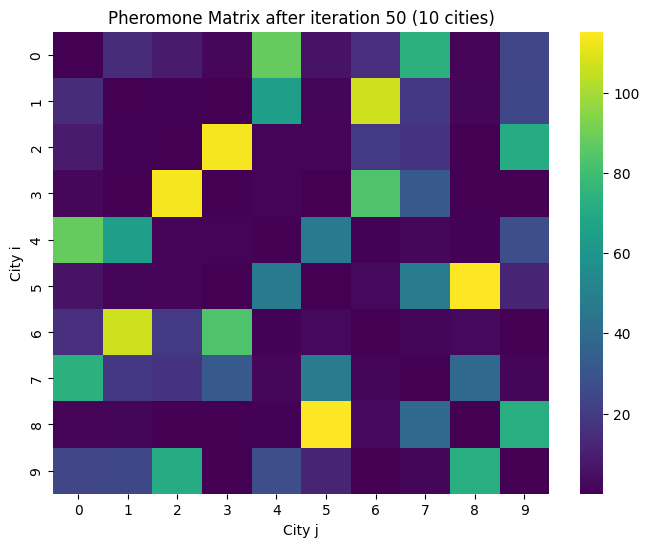

In [280]:
colony_10 = Colony(graph_10, num_ants=10)
colony_10.run(iterations=50)
plot_pheromone_snapshots(colony, num_cities=10)



## Results for 20 cities

In [281]:
print("\nResults for 20 cities:")

best_costs_dict = {}
avg_costs_dict = {}

for n_ants in ants_list:
    colony = Colony(graph_20, num_ants=n_ants)
    best_path, best_cost, best_costs_list, avg_costs_list = colony.run()
    print(f"Ants: {n_ants} -> Best path cost: {best_cost}")
    best_costs_dict[n_ants] = best_costs_list
    avg_costs_dict[n_ants] = avg_costs_list


Results for 20 cities:
Iteration 10/50, Best cost: 155
Iteration 20/50, Best cost: 155
Iteration 30/50, Best cost: 155
Iteration 40/50, Best cost: 155
Iteration 50/50, Best cost: 155
Ants: 1 -> Best path cost: 155
Iteration 10/50, Best cost: 161
Iteration 20/50, Best cost: 161
Iteration 30/50, Best cost: 161
Iteration 40/50, Best cost: 161
Iteration 50/50, Best cost: 161
Ants: 5 -> Best path cost: 161
Iteration 10/50, Best cost: 159
Iteration 20/50, Best cost: 159
Iteration 30/50, Best cost: 159
Iteration 40/50, Best cost: 159
Iteration 50/50, Best cost: 159
Ants: 10 -> Best path cost: 159
Iteration 10/50, Best cost: 158
Iteration 20/50, Best cost: 155
Iteration 30/50, Best cost: 148
Iteration 40/50, Best cost: 148
Iteration 50/50, Best cost: 148
Ants: 20 -> Best path cost: 148


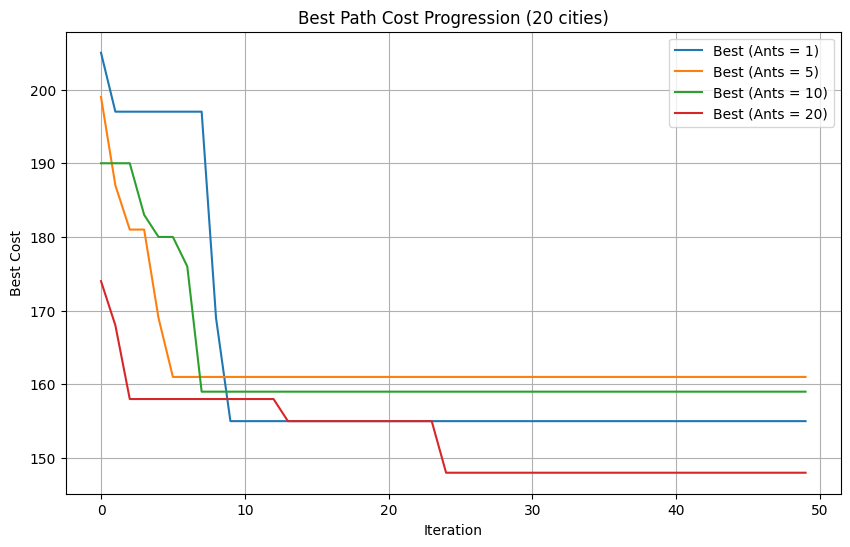

In [282]:
# Plot 1: Best cost per iteration
plt.figure(figsize=(10, 6))
for n_ants in ants_list:
    plt.plot(best_costs_dict[n_ants], label=f'Best (Ants = {n_ants})')
plt.title('Best Path Cost Progression (20 cities)')
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.legend()
plt.grid(True)
plt.show()

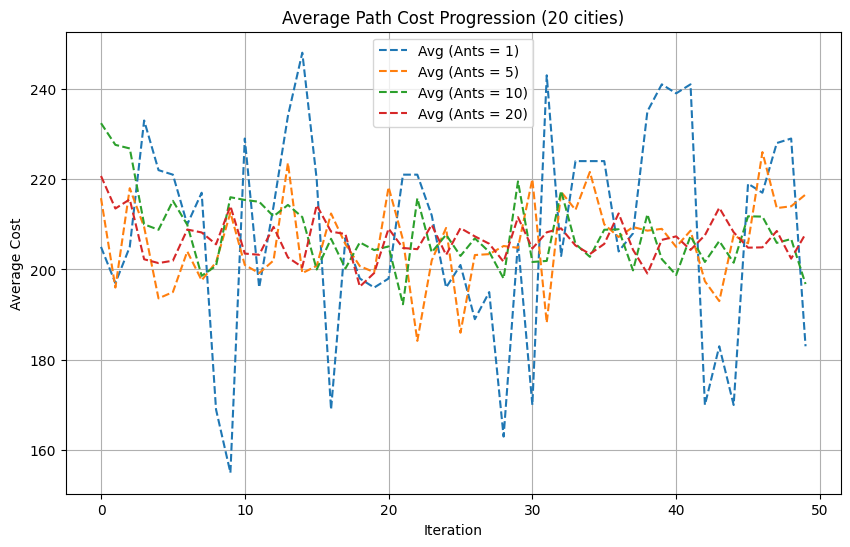

In [283]:
# Plot 2: Average cost per iteration
plt.figure(figsize=(10, 6))
for n_ants in ants_list:
    plt.plot(avg_costs_dict[n_ants], linestyle='--', label=f'Avg (Ants = {n_ants})')
plt.title('Average Path Cost Progression (20 cities)')
plt.xlabel('Iteration')
plt.ylabel('Average Cost')
plt.legend()
plt.grid(True)
plt.show()


Iteration 10/50, Best cost: 166
Iteration 20/50, Best cost: 166
Iteration 30/50, Best cost: 160
Iteration 40/50, Best cost: 157
Iteration 50/50, Best cost: 157
Visualizing pheromone snapshots for 20 cities...


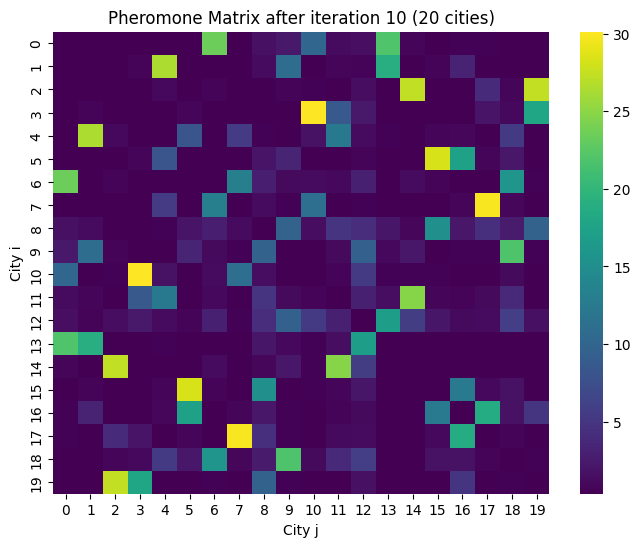

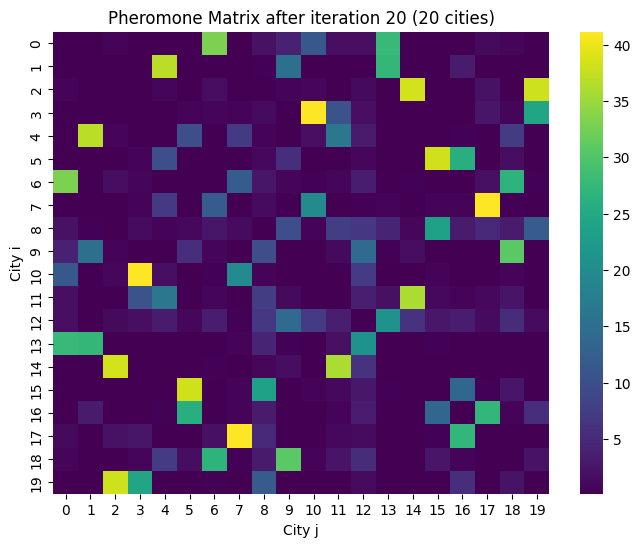

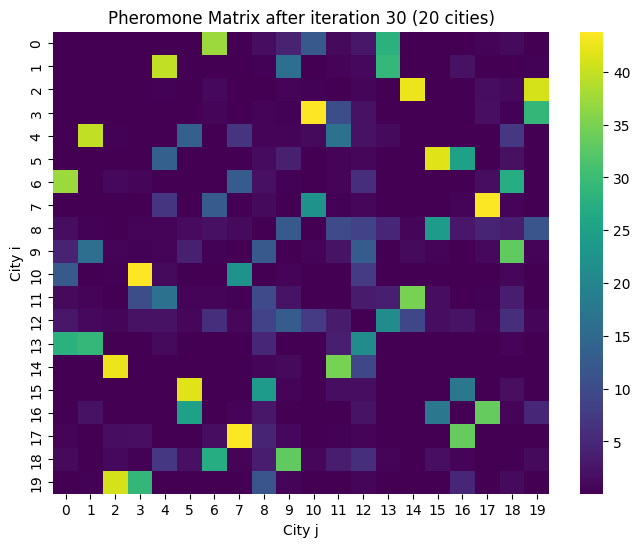

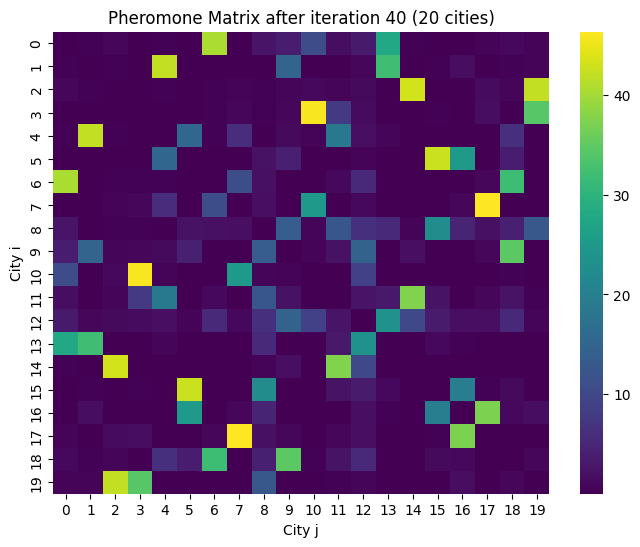

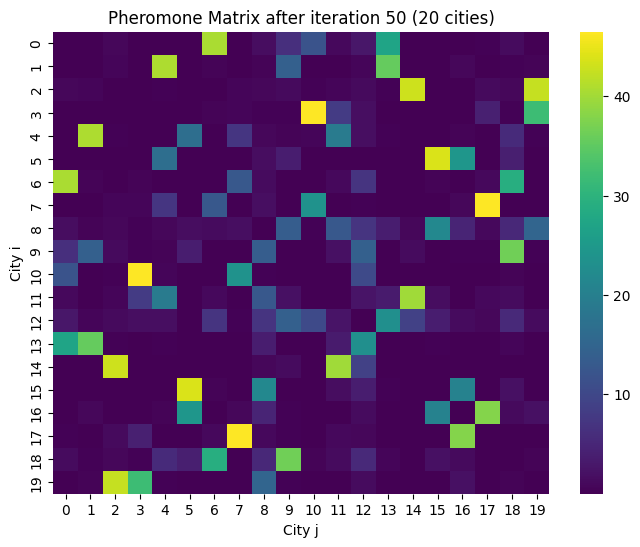

In [284]:
colony_20 = Colony(graph_20, num_ants=10)
colony_20.run(iterations=50)
plot_pheromone_snapshots(colony_20, 20)